<h2 style="color: white; background-color: #2A3F07; margin: 20px 0; padding: 30px 15px; border-radius: 4px;">
    🥑 Avocado Price Optimisation 💰
</h2>

<img src="images/avocado-banner.jpg" alt="Avocado Banner" style="display: block; width: 100%; max-height: 200px; object-fit: cover; border-radius: 4px; margin: 20px 0;">


<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">Table of Contents</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

1. [Background Context](#background-context)
2. [Notebook Setup](#notebook-setup)
3. [Data Collection and Description](#data-collection-description)
4. [Data Loading](#data-loading)
5. [Data Cleaning and Filtering](#data-cleaning-filtering)
6. [Exploratory Data Analysis](#exploratory-data-analysis)
7. [Modeling Avocado Sales](#modeling)
8. [Optimising Avocado Prices](#optimisation)
9. [Conclusion](#conclusion)
10. [References](#references)

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="background-context" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">1. Background Context</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

Setting product prices requires a careful balance between profitability and consumer demand. While higher price points can lead to greater profit margins per unit sold, consumers may be less willing to pay a premium, especially in cases where competition and the rising cost of living play significant roles in purchasing decisions. 

Avocados, known for their versatility in the kitchen, have earned a reputation as a luxury item in certain regions due to their relatively high price compared to other fruits and their association with modern, health-conscious lifestyles. Due to their high demand, consumers often anticipate paying more for avocados compared to other fruits. However, key questions remain: how much are consumers willing to pay, and what impact does pricing have on consumer purchasing decisions? Answering these questions is crucial for avocado retailers aiming to maximise profits while maintaining strong consumer demand. In recent years, machine learning has emerged as a valuable tool for predicting consumer demand based on pricing and other key factors. 

**The aim of this project is to** (i) forecast avocado demand, considering factors such as pricing, variety, region, and seasonality, and (ii) optimise pricing strategies to align with demand, ensuring profitability and sustained consumer interest. To do this, a combination of machine learning and optimisation algorithms will be used.

**We hypothesise that** avocado demand is influenced by a combination of factors, including price, variety and seasonality, and that machine learning models can accurately predict consumer demand based on these variables. Additionally, we expect that optimised pricing strategies, tailored to specific regions and seasons, will result in increased profitablity without significantly reducing demand.

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="notebook-setup" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">2. Notebook Setup</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

Import packages

In [601]:
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.optimize import minimize

import mlflow
from matplotlib.colors import LinearSegmentedColormap
from IPython.core.display import HTML
from pylab import rcParams

Turn off warning notifications

In [602]:
import warnings

warnings.filterwarnings("ignore")

Choose notebook color palettes

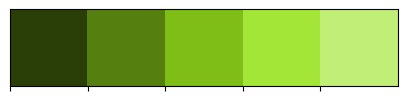

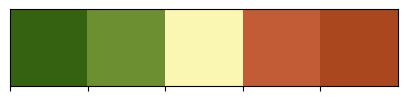

In [603]:
greens = ["#2A3F07", "#557F0F", "#7FBE17", "#A4E637", "#C1EE76"]
mixed = ["#356211", "#6C8F32", "#F9F7B2", "#C15C37", "#AA471F"]

# Create custom color map
mixed_cmap = LinearSegmentedColormap.from_list("mixed_cmap", mixed)
greens_cmap = LinearSegmentedColormap.from_list("greens_cmap", greens)

sns.palplot(greens)
sns.palplot(mixed)

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="data-collection-description" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">3. Data Collection and Description</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

Weekly US avocado sales and pricing data, collected by the Hass Avocado Board between 2015 and 2023, was used for this project. The data was obtained from Kaggle at this [link](https://www.kaggle.com/datasets/vakhariapujan/avocado-prices-and-sales-volume-2015-2023/data) and is stored in the `Data/Avocado_HassAvocadoBoard_20152023.csv` file. 

The data consists of 12 features and 53.4k observations.
The features are as follows:

* `Date` (datetime): The date of data recording.
* `AveragePrice` (float): The average selling price of a single volume unit of avocados.
* `TotalVolume` (float): The total volume of avocados sold.
* `plu4046` (float): The volume of small/medium hass avocados (~3-5oz) sold in the week.
* `plu4225` (float): The volume of small/medium hass avocados (~8-10oz) sold in the week.
* `plu4770` (float): The volume of extra large hass avocados (~10-15oz) sold in the week.
* `TotalBags` (float): The volume of bags sold in the week. Bags consist of a variable number of avocados of mixed PLU type.
* `SmallBags` (float): The volume of small bags sold in the week. Bags consist of a variable number of avocados of mixed PLU type.
* `LargeBags` (float): The volume of of large bags sold in the week. Bags consist of a variable number of avocados of mixed PLU type.
* `XLargeBags` (float): The volume of of extra large bags sold in the week. Bags consist of a variable number of avocados of mixed PLU type.
* `type` (str): The type of avocado (conventional/organic).
* `region` (str): Regions and sub-regions in the US in which the avocados were sold. Total US sales are also included.

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="data-loading" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">4. Data Loading</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

In [604]:
avo_data = pd.read_csv(r"Data/Avocado_HassAvocadoBoard_20152023.csv", sep=",")
avo_data.head(5)

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,BaltimoreWashington


In [605]:
# Filter regions
regions = [
    "California",
    "West",
    "Plains",
    "SouthCentral",
    "Southeast",
    "Midsouth",
    "GreatLakes",
    "Northeast",
]
avo_data = avo_data[avo_data.region.isin(regions)]

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="data-cleaning-filtering" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">5. Data Cleaning and Filtering</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

To simplify the analysis, we will be focusing on individual unit sales only. Remove data on avocado bag sales.

In [606]:
avo_data = avo_data.drop(
    columns=["TotalVolume", "TotalBags", "SmallBags", "LargeBags", "XLargeBags"]
)

Remove sub-regional and total US sales data. Keep US regional data only.

In [607]:
regions = [
    "California",
    "West",
    "Plains",
    "SouthCentral",
    "Southeast",
    "Midsouth",
    "GreatLakes",
    "Northeast",
]
avo_data = avo_data[avo_data.region.isin(regions)]

To assist with spotting errors in the data, print summary statistics for the numerical columns.

In [608]:
avo_data.describe().T

,count,mean,std,min,25%,50%,75%,max
AveragePrice,7456.0,1.392206,3.453067e-01,0.619393,1.113242,1.371662,1.649764e+00,2.58
plu4046,7456.0,812777.358403,1.065613e+06,0.000000,12693.922500,125653.515000,1.461486e+06,5160896.68
plu4225,7456.0,590396.359836,8.168833e+05,0.000000,22075.355000,149058.420000,8.772301e+05,5934192.22
plu4770,7456.0,54326.384307,1.168295e+05,0.000000,28.590000,2366.105000,4.084384e+04,1419739.17


Determine if there are any missing values.

In [609]:
avo_data.isnull().sum(axis=0)

Date            0
AveragePrice    0
plu4046         0
plu4225         0
plu4770         0
type            0
region          0
dtype: int64

Verify that the column data types are correct.

In [610]:
avo_data.dtypes

Date             object
AveragePrice    float64
plu4046         float64
plu4225         float64
plu4770         float64
type             object
region           object
dtype: object

Rename the columns in a snake_case format to facilitate ease of analysis.

In [611]:
avo_data = avo_data.rename(
    columns={"Date": "date", "AveragePrice": "average_unit_price"}
)

Extract year and month data into separate columns. Ensure that the date column is in date-time format. 

In [612]:
avo_data["year"] = pd.DatetimeIndex(avo_data["date"]).year
avo_data["month"] = pd.DatetimeIndex(avo_data["date"]).month
avo_data["date"] = pd.to_datetime(avo_data["date"])

Combine sales data into a single column.

In [613]:
avo_data = avo_data.melt(
    id_vars=["average_unit_price", "type", "region", "year", "month", "date"],
    value_vars=["plu4046", "plu4225", "plu4770"],
    var_name="plu",
    value_name="volume_sold",
)

The dataset contains weekly avocado sales data. Ensure that the data is grouped accordingly.

In [614]:
avo_data = (
    avo_data.set_index("date")
    .groupby([pd.Grouper(freq="W"), "year", "month", "type", "region", "plu"])
    .agg({"average_unit_price": "mean", "volume_sold": "sum"})
    .reset_index()
)

Change the units of the volume_sold column to millions.

In [615]:
avo_data["volume_sold"] = avo_data["volume_sold"]/1000000

View cleaned data.

In [616]:
avo_data.head(5)

,date,year,month,type,region,plu,average_unit_price,volume_sold
0,2015-01-04,2015,1,conventional,California,plu4046,0.93,2.843648
1,2015-01-04,2015,1,conventional,California,plu4225,0.93,2.267755
2,2015-01-04,2015,1,conventional,California,plu4770,0.93,0.137480
3,2015-01-04,2015,1,conventional,GreatLakes,plu4046,1.02,0.467259
4,2015-01-04,2015,1,conventional,GreatLakes,plu4225,1.02,2.059658


Save the cleaned data to a CSV file.

In [617]:
avo_data.to_csv("Data/Avocado_HassAvocadoBoard_cleaned_20152023.csv")

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="exploratory-data-analysis" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">6. Exploratory Data Analysis</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.1. Distribution of Categorical Variables</h2>

Examine the distribution of categorical variables. An imbalanced distribution may bias a regression model toward more frequent categories when predicting sales demand.

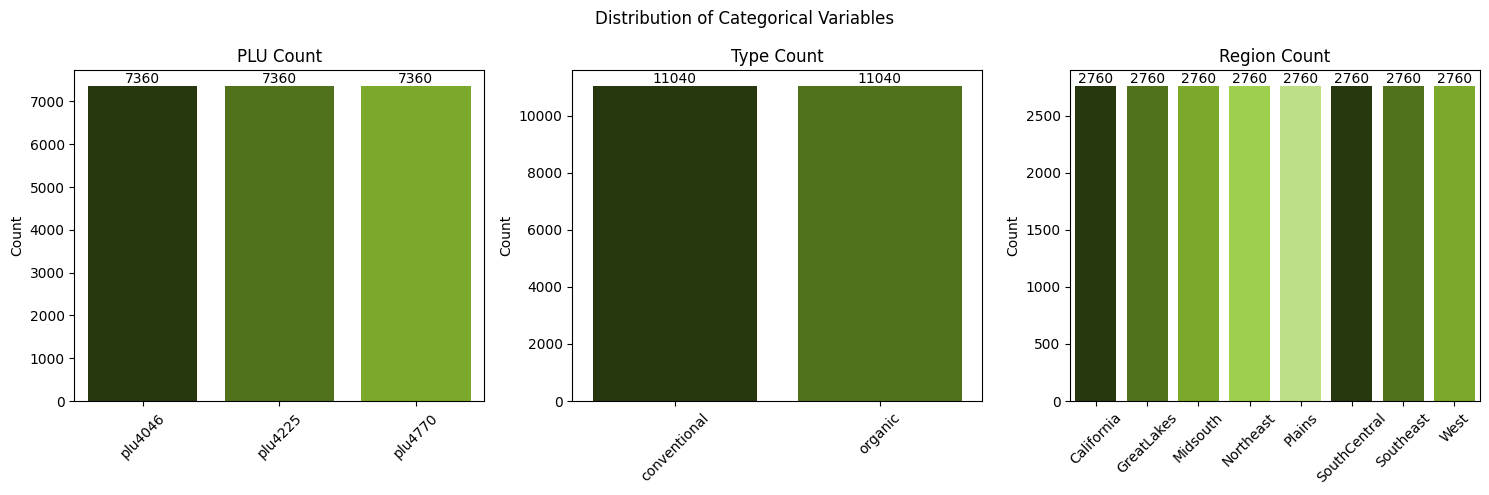

In [618]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Categorical Variables")

# Plot categorical variable counts
cat_variables = ["plu", "type", "region"]
palettes = [greens, ["#6C8F32", "#AA471F"], list(greens_cmap(np.linspace(0, 1, 8)))]
titles = ["PLU Count", "Type Count", "Region Count"]

for i in range(0, 3):
    sns.countplot(
        data=avo_data,
        x=cat_variables[i],
        ax=axs[i],
        hue=cat_variables[i],
        palette=greens,
    )
    axs[i].set_title(titles[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel("Count")
    axs[i].tick_params(axis="x", rotation=45)

    # Add bar labels
    for container in axs[i].containers:
        axs[i].bar_label(container)

# Adjust layout
plt.tight_layout()
plt.show()

The plots above show balanced distributions of the categorical variables:

* PLU Count: The three PLU codes (plu4046, plu4225, plu4770) are evenly distributed with 7456 observations each.
* Type Count: Conventional and organic types are evenly distributed with 11184 counts each.
* Region Count: All regions have 2796 counts, indicating a uniform distribution of data across regions.

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.2. Distribution of Numerical Variables</h2>

Examine the distribution of numerical variables. If features have highly skewed distributions the regression models may not perform as well, especially in the case of linear regression which assumes that numerical features follow a normal distribution.

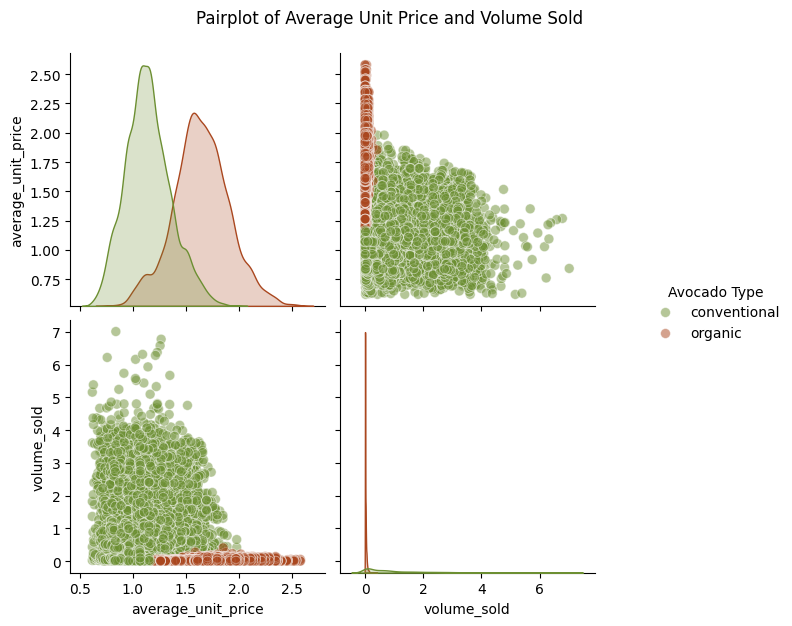

In [619]:
# Create a pairplot
pairplot = sns.pairplot(
    data=avo_data[["type", "average_unit_price", "volume_sold"]],
    plot_kws={"alpha": 0.5, "s": 50, "edgecolor": "w"},
    hue="type",
    palette=["#6C8F32", "#AA471F"],
)

# Set the chart title, axis labels and size
pairplot.fig.suptitle("Pairplot of Average Unit Price and Volume Sold", y=1.05)
pairplot._legend.set_title("Avocado Type")
pairplot.fig.set_size_inches(8, 6)

plt.show()

The pairplot visualises the distribution of average unit price and volume sold, and the relationship between the two variables, distinguishing between two avocado types: conventional (green) and organic (brown).

The following insights are apparent:
 
* The prices of organic avocados tend to have a normal distribution with higher average prices compared to convention avocados, mostly ranging between 1.50 and 2.50 Dollars.
* The prices of conventional avocados also follow a normal distribution, but are generally cheaper, with prices ranging between 0.75 and 1.50 Dollars.
* The sales of organic avocados are more consistent in comparison to conventional avocados, with less fluctuation due to price. This is indicative of a stable market, with a low price elasticity.
* Conventional avocado sales are skewed to the right. This may be due to the presence of outliers, which may need to be removed if linear regression models are constructed. Conventional avocados have a much higher number of volume sold compared to organic, with a large number of data points clustered on the lower end of the average unit price. 

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.3. The Effect of Avocado Variety on Sales and Pricing</h2>

To determine whether sales and pricing differ for different avocado varieties, compare sales and pricing for different PLU codes (plu4046, plu4225, plu4770) for both conventional and organic avocados. 

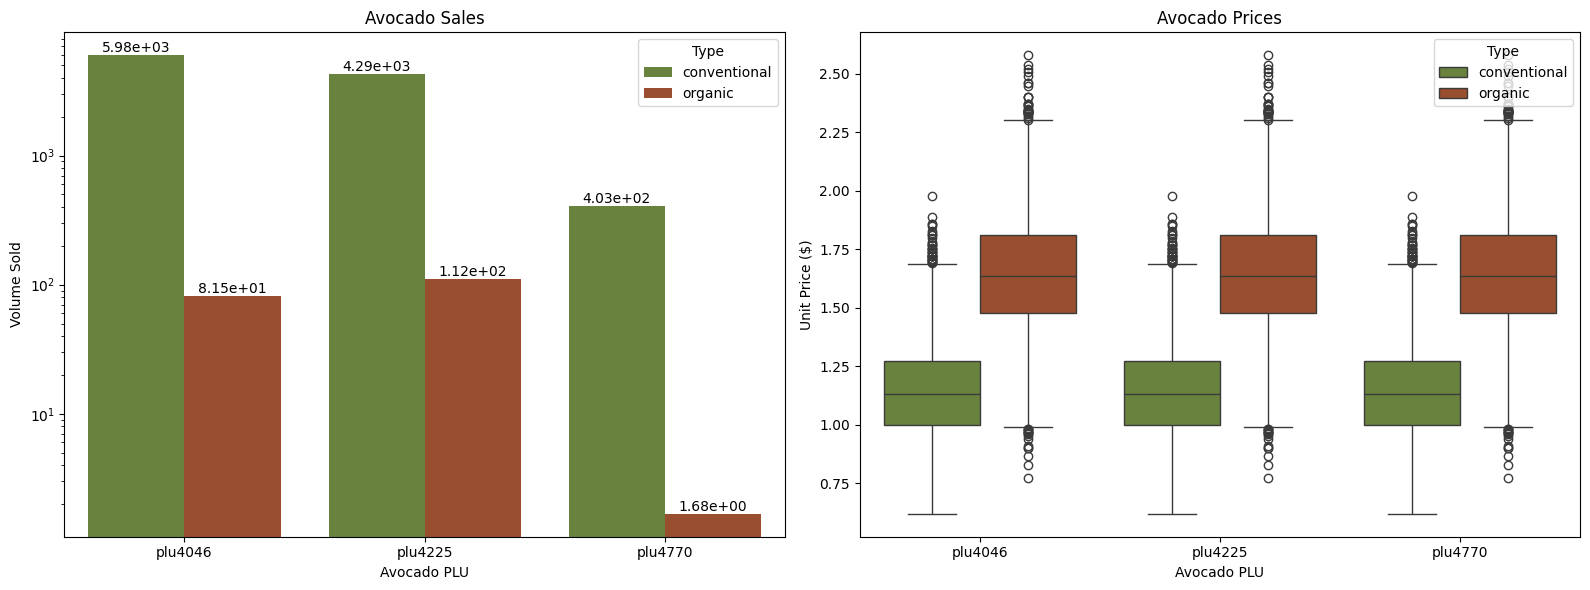

In [620]:
# Calculate sales by type and PLU
sales_data_by_variety = (
    avo_data.groupby(["plu", "type"])[["volume_sold"]].sum().reset_index()
)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Sales by PLU and type
sns.barplot(
    data=sales_data_by_variety,
    x="plu",
    y="volume_sold",
    hue="type",
    palette=["#6C8F32", "#AA471F"],
    ax=axs[0],
)
axs[0].set(title="Avocado Sales", xlabel="Avocado PLU", ylabel="Volume Sold")
axs[0].set_yscale("log")
axs[0].legend(title="Type", loc="upper right")

# Add bar labels
for container in axs[0].containers:
    axs[0].bar_label(container, fmt="%.2e")

# Plot 2: Prices by PLU and type
sns.boxplot(
    data=avo_data,
    x="plu",
    y="average_unit_price",
    hue="type",
    palette=["#6C8F32", "#AA471F"],
    ax=axs[1],
)
axs[1].set(title="Avocado Prices", xlabel="Avocado PLU", ylabel="Unit Price ($)")
axs[1].legend(title="Type", loc="upper right")

# Adjust layout
plt.tight_layout()
plt.show()

The insights are as follows. 

Sales:
* Conventional avocados dominate in terms of volume sold across all PLUs.
* The sales volume for plu4046 is the highest for both types, followed by plu4225 and plu4770.
* Organic avocados have significantly lower sales compared to conventional ones, particularly for plu4770.

Pricing:
* Organic avocados consistently have higher prices than conventional avocados across all PLUs.
* The boxplots show a wider price range for organic avocados, with more variation.
* Conventional avocados show a narrower price range with lower median prices.

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.4. Regional Differences in Avocado Sales and Pricing</h2>

To determine whether sales and pricing differ for different US regions, compare sales and pricing across the regions for conventional and organic avocados. 

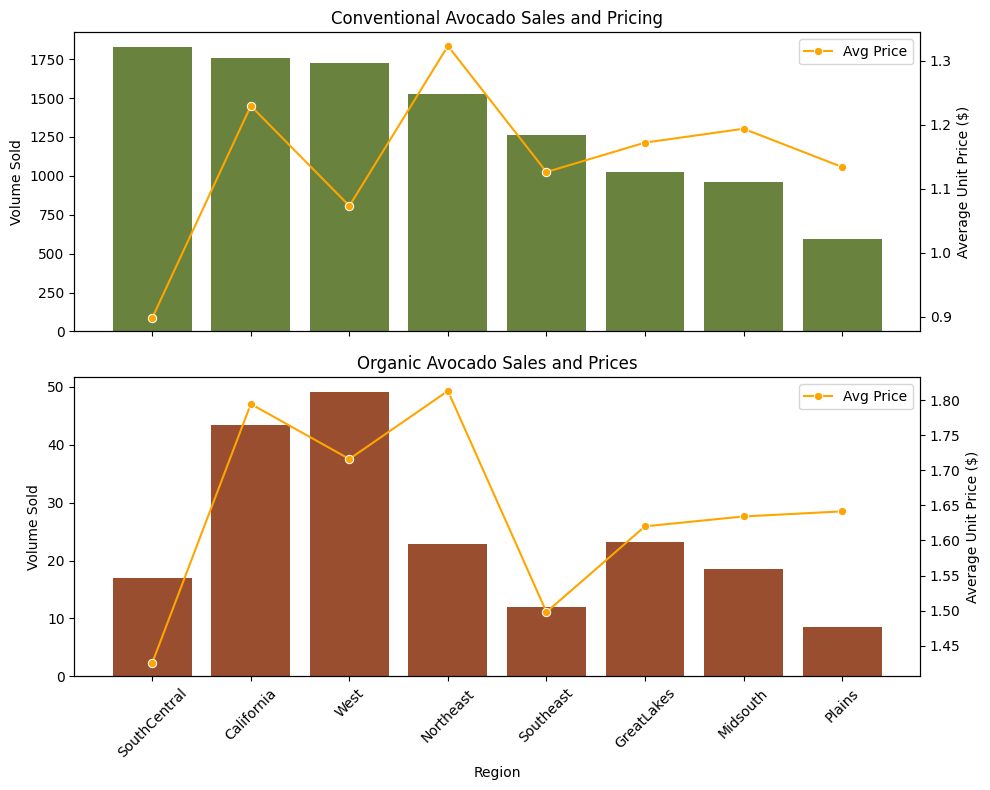

In [621]:
# Calculate sales and average prices for conventional avocados
regional_conv_avo_sales = (
    avo_data[avo_data.type == "conventional"][["region", "volume_sold"]]
    .groupby(["region"])
    .sum()
    .reset_index()
    .sort_values(by="volume_sold", ascending=False)
)
regional_conv_avo_prices = (
    avo_data[avo_data.type == "conventional"][["region", "average_unit_price"]]
    .groupby("region")
    .mean()
    .reset_index()
)

# Calculate sales and average prices for organic avocados
regional_org_avo_sales = (
    avo_data[avo_data.type == "organic"][["region", "volume_sold"]]
    .groupby(["region"])
    .sum()
    .reset_index()
    .sort_values(by="volume_sold", ascending=False)
)
regional_org_avo_prices = (
    avo_data[avo_data.type == "organic"][["region", "average_unit_price"]]
    .groupby("region")
    .mean()
    .reset_index()
)

# Set up the figure and axs
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
sales_data = [regional_conv_avo_sales, regional_org_avo_sales]
pricing_data = [regional_conv_avo_prices, regional_org_avo_prices]
colors = ["#6C8F32", "#AA471F"]
titles = ["Conventional Avocado Sales and Pricing", "Organic Avocado Sales and Prices"]

for i in range(0, 2):
    ax1 = axs[i]
    sns.barplot(
        x="region",
        y="volume_sold",
        data=sales_data[i],
        ax=ax1,
        color=colors[i],
        label="Volume Sold",
    )
    ax2 = ax1.twinx()
    sns.lineplot(
        x="region",
        y="average_unit_price",
        data=pricing_data[i],
        ax=ax2,
        marker="o",
        color="orange",
        label="Avg Price",
    )
    ax1.set_title(titles[i])
    ax1.set_xlabel("Region")
    ax1.set_ylabel("Volume Sold")
    ax2.set_ylabel("Average Unit Price ($)")
    ax1.tick_params(axis="x", rotation=45)
    ax1.get_legend().remove()

# Adjust layout to increase spacing between subplots
plt.subplots_adjust(hspace=10)

# Display the plot
plt.tight_layout()
plt.show()

This figure above shows avocado sales (as bar charts) and average unit prices (as line plots) for conventional and organic avocado types across various regions. The insights are as follows:

**Conventional Avocados**
   - Sales
     - Highest volume sold are in regions like *South Central*, *California*, and *West*.
     - Lowest sales are in the *Plains* region.
   - Pricing
     - The average price fluctuates across regions, with the highest in *North East* and the lowest in the *South Central* region.
   - Relationship between Sales and Pricing
     - Pricing seems to be higher in regions with higher sales (with the exception of the South Central region).

**Organic Avocados**
   - Sales
     - Highest volume sold are in *California* and the *West* regions.
     - Lowest volume sold are in the *Plains* and *Southeast* regions.
   - Pricing
     - The average price fluctuates across regions. The *West* region has the highest prices, while *South Central* has relatively lower prices compared to other regions.
   - Relationship between Sales and Pricing
     - Pricing seems to be higher in regions with higher sales.

**Comparative Summary**
- *Conventional Avocados* have a higher total sales volume compared to *Organic Avocados*, especially in high-population regions like *South Central* and *Northeast*.
- *Organic Avocados* tend to have higher prices, but the total sales are much lower than *Conventional Avocados*.
- The pricing patterns across regions are similar between *Conventional* and *Organic* avocados.

This data suggests that *Conventional Avocados* are more popular in terms of sales volume, but *Organic Avocados* have a niche market with higher pricing, especially in some regions like *West* and *California*.

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.5. Annual Fluctuations in Avocado Sales and Pricing</h2>

To gain an idea of the annual fluctuations in avocado sales and pricing, plot average annual sales and pricing statistics from 2015 to 2023.

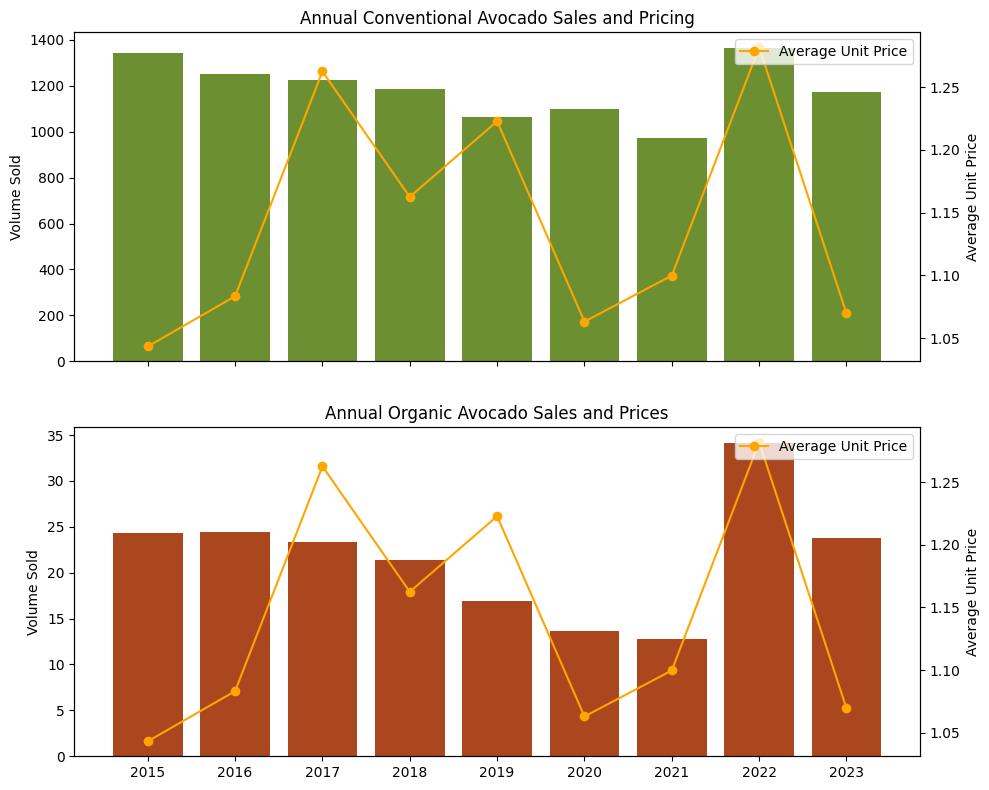

In [622]:
# Calculate the total yearly avocado sales by year and by PLU
annual_conv_avo_sales = (
    avo_data[avo_data.type == "conventional"][["year", "volume_sold"]]
    .groupby("year")
    .sum()
    .reset_index()
)
annual_conv_avo_prices = (
    avo_data[avo_data.type == "conventional"][["year", "average_unit_price"]]
    .groupby("year")
    .mean()
    .reset_index()
    .set_index("year")
)

annual_org_avo_sales = (
    avo_data[avo_data.type == "organic"][["year", "volume_sold"]]
    .groupby("year")
    .sum()
    .reset_index()
)
annual_org_avo_prices = (
    avo_data[avo_data.type == "organic"][["year", "average_unit_price"]]
    .groupby("year")
    .mean()
    .reset_index()
    .set_index("year")
)

# Set up the figure and axs
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
sales_data = [annual_conv_avo_sales, annual_org_avo_sales]
pricing_data = [annual_conv_avo_prices, annual_org_avo_prices]
colors = ["#6C8F32", "#AA471F"]
titles = ["Annual Conventional Avocado Sales and Pricing", "Annual Organic Avocado Sales and Prices"]

for i in range(0,2):
    ax1 = axs[i]
    ax2 = ax1.twinx()
    ax1.bar(
        sales_data[i]["year"], sales_data[i]["volume_sold"], color=colors[i]
    )
    ax2.plot(annual_conv_avo_prices, color="orange", marker="o", label="Average Unit Price")
    ax1.set_title(titles[i])
    ax1.set_ylabel("Volume Sold")
    ax2.set_ylabel("Average Unit Price")
    ax1.set_xticks(sales_data[i]["year"])
    ax2.legend(loc="upper right")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.show()

This figure above shows the annual fluctuations in avocado sales and pricing for conventional and organic avocados from 2015 to 2023. The insights are as follows:

**Conventional Avocados:**
   - Sales Volume:
     - Fairly stable between 2015 and 2023, with a slight dip in 2019 and 2021.
     - A notable increase in 2022 with the highest volume sold over the observed period.
   - Price Trends:
     - Prices were highest in 2017 but have been on a downward trend since, with the lowest price recorded in 2023.
     - The drop in price from 2022 to 2023 is significant, despite a high sales volume in 2022.

**Organic Avocados:**
   - Sales Volume:
     - A more varied trend compared to conventional avocados.
     - Lowest sales occurred in 2021, with a significant recovery in 2022.
     - However, sales dropped again in 2023.
   - Price Trends:
     - Price peaks occurred in 2019 and 2022.
     - Similar to conventional avocados, there was a significant price drop in 2023.

**Comparative Summary**
  - Both conventional and organic avocados saw a price peak in 2017 and a notable price drop in 2023. 
  - Both avocado types experienced a rise in sales in 2022, but a sharp drop in price in 2023 for conventional avocados, suggesting potential market saturation or other factors affecting pricing.

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.6. Seasonal Sales Trends</h2>

Based on the annual trends observed in the previous plots, some years exhibited higher average sales than others. A logical next step is to analyse whether specific months of the year show consistently higher average sales. The following plots aim to address this.

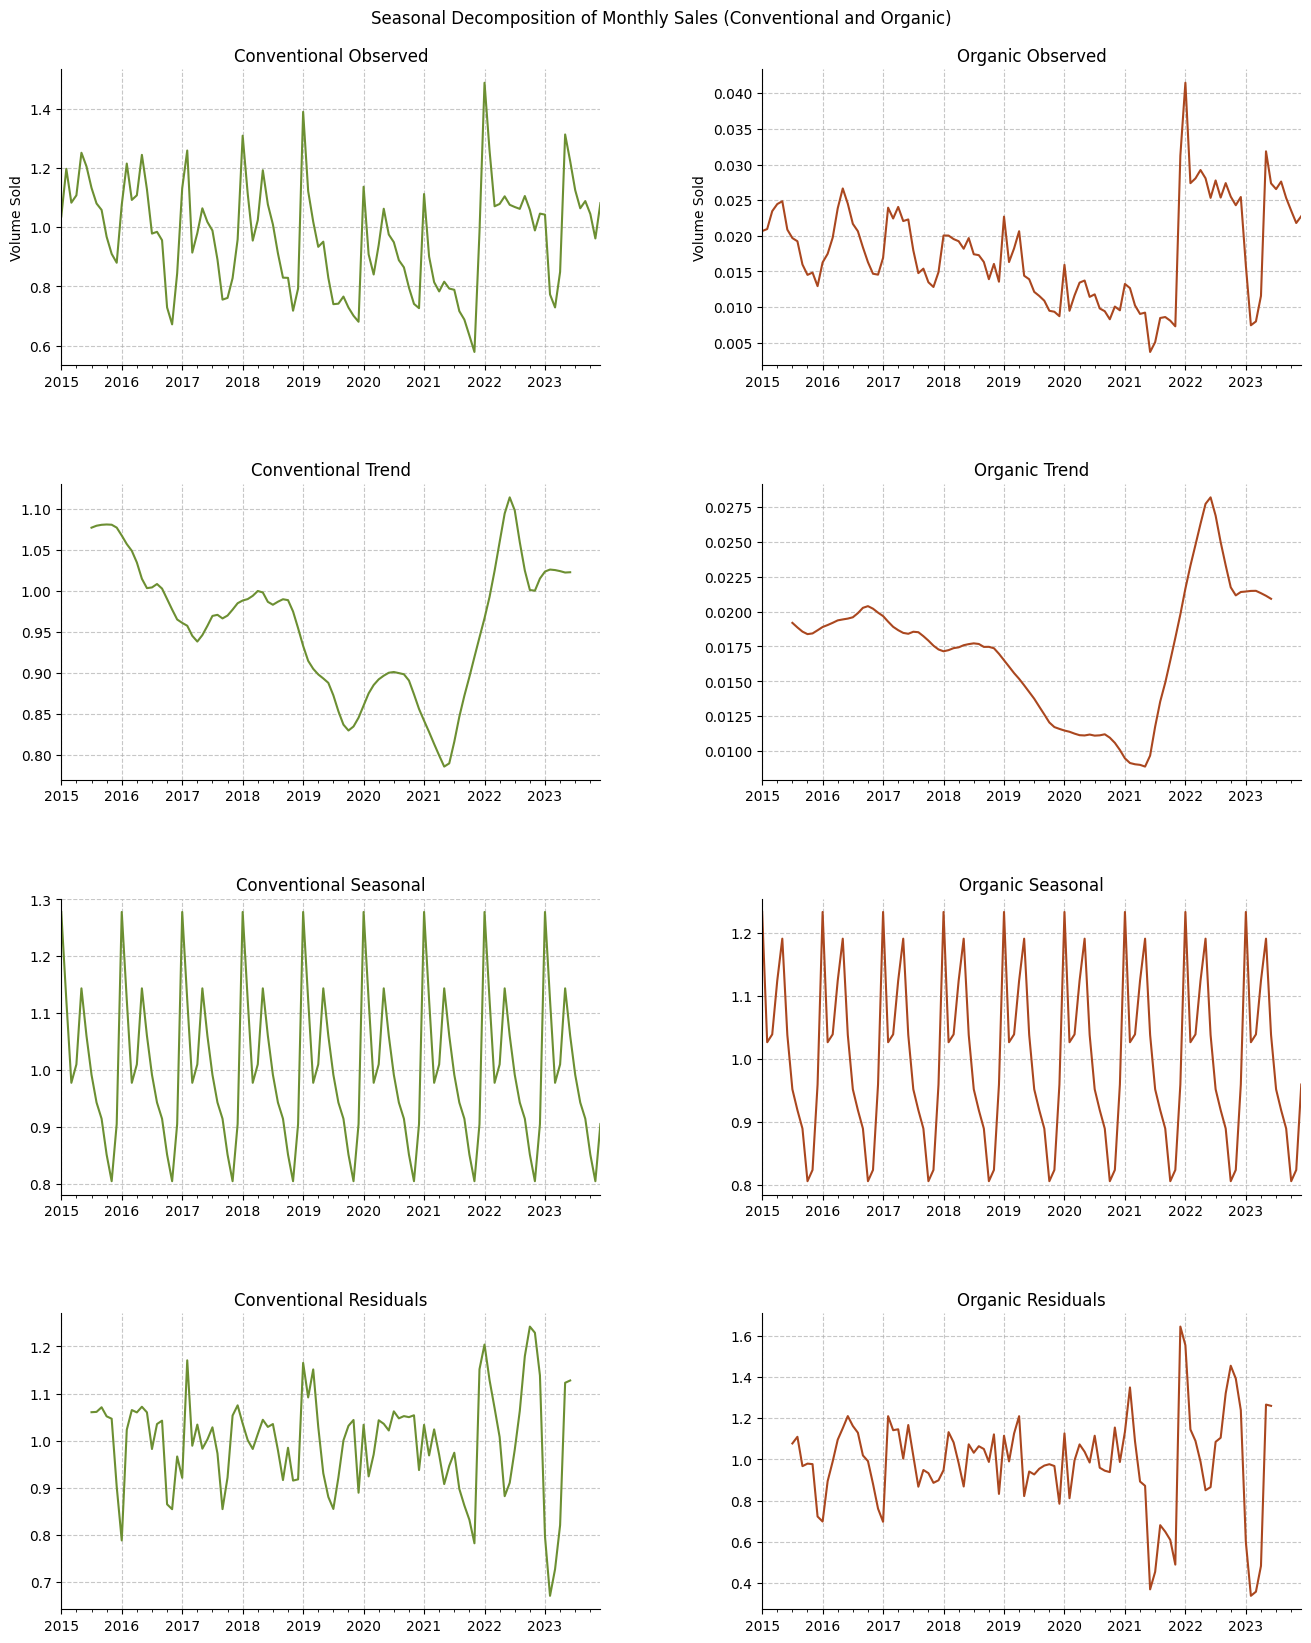

In [623]:
# Get total monthly sales for conventional and organic avocados
avo_data["date"] = pd.to_datetime(avo_data["date"])

conv_sales_data = (
    avo_data[avo_data.type == "conventional"][["date", "volume_sold"]]
    .groupby(pd.Grouper(key="date", freq="M"))
    .mean()
)

org_sales_data = (
    avo_data[avo_data.type == "organic"][["date", "volume_sold"]]
    .groupby(pd.Grouper(key="date", freq="M"))
    .mean()
)

# Set up the figure size and decompositions
rcParams["figure.figsize"] = 12, 20  # Increase height for 4 rows
conv_decomposition = sm.tsa.seasonal_decompose(conv_sales_data, model="multiplicative")
org_decomposition = sm.tsa.seasonal_decompose(org_sales_data, model="multiplicative")

# Create the figure and subplots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))  # 4 rows, 2 columns

# Plot for conventional avocados decomposition (trend, seasonal, and residuals)
conv_decomposition.observed.plot(
    ax=axs[0, 0], title="Conventional Observed", ylabel="Volume Sold", color="#6C8F32"
)
conv_decomposition.trend.plot(ax=axs[1, 0], title="Conventional Trend", color="#6C8F32")
conv_decomposition.seasonal.plot(
    ax=axs[2, 0], title="Conventional Seasonal", color="#6C8F32"
)
conv_decomposition.resid.plot(
    ax=axs[3, 0], title="Conventional Residuals", color="#6C8F32"
)

# Plot for organic avocados decomposition (trend, seasonal, and residuals)
org_decomposition.observed.plot(
    ax=axs[0, 1], title="Organic Observed", ylabel="Volume Sold", color="#AA471F"
)
org_decomposition.trend.plot(ax=axs[1, 1], title="Organic Trend", color="#AA471F")
org_decomposition.seasonal.plot(ax=axs[2, 1], title="Organic Seasonal", color="#AA471F")
org_decomposition.resid.plot(ax=axs[3, 1], title="Organic Residuals", color="#AA471F")

# Customize the overall plot
fig.suptitle(
    "Seasonal Decomposition of Monthly Sales (Conventional and Organic)", y=0.91
)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Customizing the individual subplots (remove top and right borders, add grid)
for ax in fig.axes:
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel(None)

# Show the plot
plt.show()

This figure illustrates a seasonal decomposition of monthly sales for conventional and organic avocados from 2015 to 2023. The insights are as follows:

**Conventional Avocados:**
- Observed Sales: Show consistent seasonal fluctuations with high sales around mid-year.
- Trend: Overall decreasing trend until 2022 followed by a sharp rise in 2022.
- Seasonality: Clear annual peaks and troughs reflecting strong seasonal patterns.
- Residuals: Larger fluctuations in residuals over time, indicating less predictability or more external influences impacting sales over time.

**Organic Avocados:**
- Observed Sales: Less consistent, with notable spikes and drops.
- Trend: Overall decreasing trend until 2022 followed by a sharp rise in 2022.
- Seasonality: Strong and consistent seasonal spikes evident yearly.
- Residuals: Larger fluctuations in residuals over time, indicating less predictability or more external influences impacting sales over time.

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.7. Relationship between Sales and Pricing</h2>

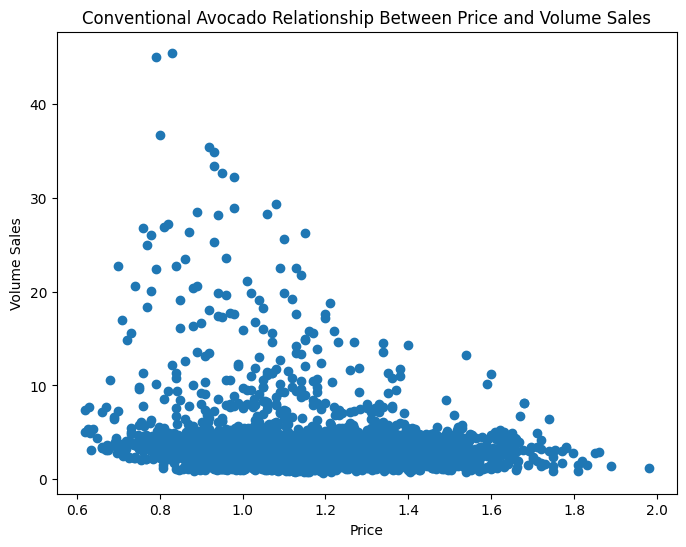

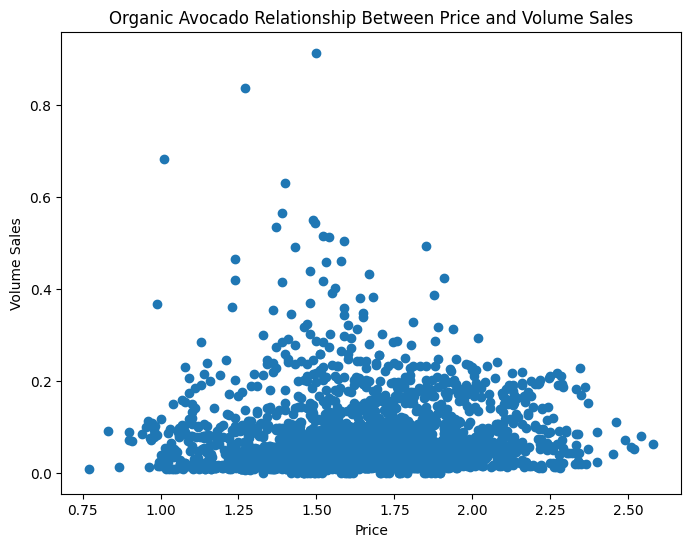

In [624]:
# Plot the relationship between sales and price for conventional avocados
conv_avo_data = avo_data[avo_data["type"]=="conventional"][["region", "average_unit_price", "volume_sold"]].groupby(["region", "average_unit_price"]).sum().reset_index()
plt.figure(figsize=(8,6))
plt.scatter(x=conv_avo_data["average_unit_price"], y=conv_avo_data["volume_sold"])
plt.title("Conventional Avocado Relationship Between Price and Volume Sales")
plt.xlabel("Price")
plt.ylabel("Volume Sales")
plt.show()

# Plot the relationship between sales and price for organic avocados
org_avo_data = avo_data[avo_data["type"]=="organic"][["region", "average_unit_price", "volume_sold"]].groupby(["region", "average_unit_price"]).sum().reset_index()
plt.figure(figsize=(8,6))
plt.scatter(x=org_avo_data["average_unit_price"], y=org_avo_data["volume_sold"])
plt.title("Organic Avocado Relationship Between Price and Volume Sales")
plt.xlabel("Price")
plt.ylabel("Volume Sales")
plt.show()

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">6.8. Factors Exhibiting a Linear Effect on Sales</h2>

To identify factors that have a linear relationship with sales, plot the correlation between units sold and region, price, PLU and type. Since region, PLU and type are categorical variables, first use one-hot encoding to create separate binary columns for each category. 

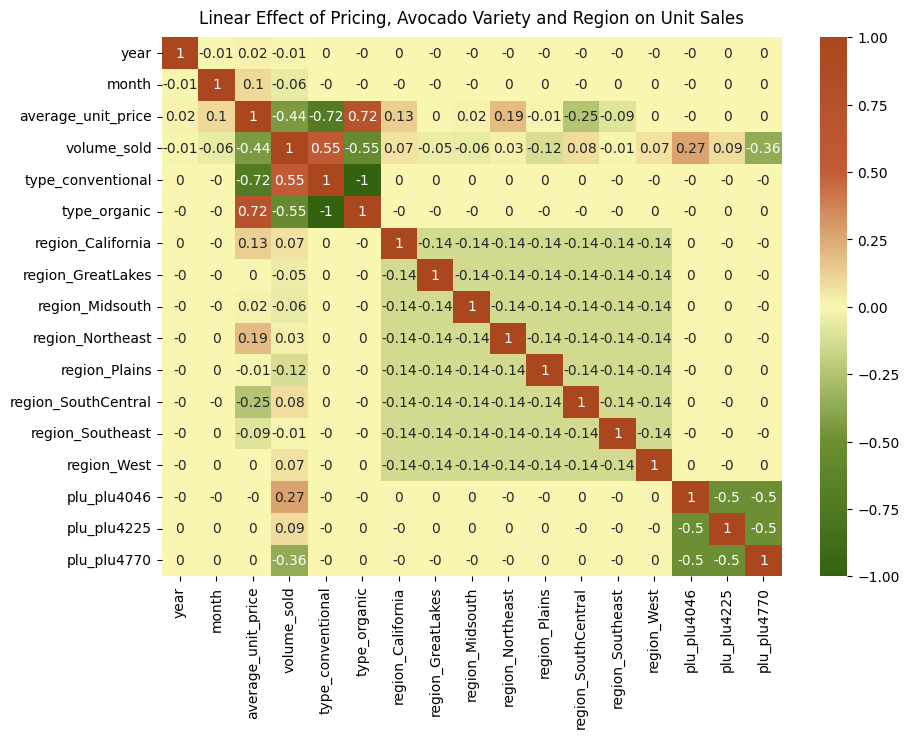

In [625]:
# Use one-hot encoding to convert categorical variables into binary values
corr_data = pd.get_dummies(
    avo_data.drop(columns=["date"]),
    columns=["type", "region", "plu"],
    drop_first=False,
)

# Calculate the correlation scores between features
correlation_values = round(corr_data.corr(), 2)

# Plot the correlation values as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(data=correlation_values, annot=True, cmap=mixed_cmap)
plt.title("Linear Effect of Pricing, Avocado Variety and Region on Unit Sales", pad=10)
plt.show()

The heatmap presents the correlation between various features, with the color scale ranging from dark green (strong negative correlation) to dark brown (strong positive correlation). Key observations are as follows:

* There is a moderate negative correlation between average unit price and volume sold (-0.44), indicating that as prices increase, sales tend to decrease.
* Conventional avocados show a moderate positive correlation with sales (0.56), while organic avocados have a negative correlation with sales (-0.56). This contrast is likely influenced by the strong correlation between avocado type and price, where organic avocados are priced higher, potentially limiting their sales compared to conventional avocados.
* The PLU codes for different avocado varieties display varying correlations with sales. For example, PLU 4046 shows a positive correlation with sales (0.28), suggesting it sells more frequently, while PLU 4770 has a negative correlation with sales (-0.36), indicating lower sales for that variety.
* Regional variables do not exhibit a significant direct correlation with sales, although the negative correlations between regions suggest the presence of multicollinearity, where regions may be interrelated in a way that affects model interpretation.

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="modeling" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">7. Modeling Avocado Sales</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">7.1. Feature Engineering</h2>

The purpose of this section is to prepare the data for model construction by selecting, adding and modifying features.

To simplify the analysis, we will focus solely on modeling the sales of conventional avocados, as organic avocado sales tend to be less sensitive to price fluctuations. Furthermore, since avocado prices are the same for all avocado PLU's a model will not be able to distinguish price elasticity between the avocado PLUs at this point. Therefore, we will combine the sales for all avocado PLUs to simplify the model.

In [626]:
avo_data = avo_data[avo_data['type']=='conventional']
avo_data = avo_data.drop(columns=["plu"]).groupby(by=["date", "year", "month", "type", "region", "average_unit_price"]).sum().reset_index()

In [627]:
avo_data = avo_data[avo_data["year"] < 2020]

Since avocado sales are influenced by seasonality, include a feature to represent the seasonality trends for conventional avocados. Sales tend to peak during the first seven months of the year, so we’ll designate these months as 'peak season' to represent this seasonality effect.

In [628]:
peak_months = range(1,8)

def is_peak(row):
    return 1 if int(row["month"]) in peak_months else 0

avo_data["peak_season"] = avo_data.apply(lambda row: is_peak(row), axis=1)

Capture additional quarterly and weekly trends. 

In [629]:
avo_data["quarter"] = pd.DatetimeIndex(avo_data["date"]).quarter
avo_data["week"] = avo_data["date"].dt.isocalendar().week

Separate the data into feature and predictor variables.

In [631]:
avo_data = avo_data.sort_values("date").set_index("date")

X = avo_data[['year', 'region', 'average_unit_price', 'peak_season', 'month', 'quarter', 'week']]
y = avo_data['volume_sold']

Split the feature and predictor variables into training and testing subsets. Set aside 20% of the data for test purposes. Maintain the order of the data, as this is important for time-series datasets.

In [632]:
# split_int = len(avo_data[avo_data["year"] < 2023])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=False, stratify=None
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1450, 7)
y_train shape: (1450,)
X_test shape: (622, 7)
y_test shape: (622,)


<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">7.2. Model Selection and Evaluation</h2>

Perform a baseline comparison of different types of regression models. To ensure that non-linear relationships are accounted for, we will model the relationship between the feature and predictor variable using non-linear models.

The models that will be compared are:

* `Random Forest (RF) Regressor`: Creates multiple decision trees built on randomly chosen subsets of the data. The model then returns a prediction output based on the aggregation of all decision trees' predictions.
* `Gradient Boosting (GB) Regressor`: An additive model composed of sequentially built decision trees that enhance the performance of the previous tree by minimising the residuals.
* `eXtreme Gradient Boosting (XGB) Regressor`: Similar to the conventional gradient boosting regressor, but optimised for performance by implementing parallel tree building and regularisation techniques.
* `Histogram-Based Gradient Boosting (HGB) Regressor`: A type of gradient boosting regressor that divides feature values into bins before training, which significantly boosts training speed while maintaining model performance.
* `AdaBoost (AB) Regressor`: An additive model composed of sequentially built decision trees that enhance the performance of the previous tree by placing greater emphasis on instances that were misclassified by prior models.

"To accurately evaluate model performance, we will create a custom scoring function to compute the Mean Absolute Error (MAE) in the original scale of the target variable. This is necessary because the predictor values were log-transformed, and we need to revert the predictions back to their original scale before calculating the error. The MAE provides a straightforward measure of the average difference between the model's predictions and the actual values, making it a useful metric for assessing prediction accuracy.

Start by creating a function to perform a baseline comparison of the models.

In [633]:
def baseline_model_comparison(model_types:dict, X_train, X_test, y_train, y_test):
    """
    Function to perform a baseline comparison of non-linear regression models.
    Arguments:
        model_types (dict): A dictionary of model names (str) and classes.
        X_train (pd.DataFrame): A dataframe of training feature values.
        X_test (pd.DataFrame): A dataframe of testing feature values.
        y_train (pd.Series): A series of training predictor values.
        y_test (pd.Series): A series of testing predictor values

    Returns:
        pd.DataFrame: Model training and prediction times and evaluation metrics.
        Figure: A figure containing subplots of model prediction vs actual values and residuals.
    """

    results = {}
    n_models = len(model_types)
    fig, axs = plt.subplots(n_models, 2, figsize=(8, 4*n_models))

    for i, (name, model) in enumerate(model_types.items()):
        
        # Model cross validation
        cv = KFold(n_splits=5, shuffle=False)

        # Define feature transformations
        feat_transform = make_column_transformer(
            (OneHotEncoder(drop='first'), ['region']),
            (StandardScaler(), ['year', 'average_unit_price', 'quarter', 'month', 'week']),
            ("passthrough", ["peak_season"]),
            verbose_feature_names_out = False,
            remainder="drop"
        )
        # Define pipeline
        pipeline = make_pipeline(feat_transform, model)

        # Cross validation
        cv_results = cross_validate(pipeline, X=X_train, y=y_train, cv=cv, n_jobs=-1, scoring=('neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'), verbose=False)
        mean_cv_results = pd.DataFrame(cv_results).mean(axis=0)
        mean_cv_results['test_mean_absolute_percentage_error'] = -mean_cv_results['test_neg_mean_absolute_percentage_error']
        mean_cv_results['test_root_mean_squared_error'] = -mean_cv_results['test_neg_root_mean_squared_error']
        results[name] = mean_cv_results

        # Train the model on the full set of training data
        pipeline.fit(X_train, y_train)
        
        # Get predicted y values
        y_pred = pipeline.predict(X_test)

        # Plot actual vs predicted values
        axs[i,0].scatter(y_test, y_pred, alpha=0.6, color='#6C8F32')
        axs[i,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axs[i,0].set_xlabel('Actual Values')
        axs[i,0].set_ylabel('Predicted Values')
        axs[i,0].set_title(f'Actual vs Predicted for {name}', fontsize=10)

        # Plot residuals
        residuals = y_test - y_pred
        axs[i,1].scatter(y_pred, residuals, alpha=0.6, color='#6C8F32')
        axs[i,1].axhline(y=0, color='r', linestyle='--')
        axs[i,1].set_xlabel('Predicted Values')
        axs[i,1].set_ylabel('Residuals')
        axs[i,1].set_title(f'Residuals Plot for {name}', fontsize=10)

    plt.tight_layout()

    return pd.DataFrame(results).T, fig

Call the function above to perform a baseline comparison of the models.

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,test_mean_absolute_percentage_error,test_root_mean_squared_error
Linear Regressor,0.010393,0.004551,-0.157013,-0.597916,0.157013,0.597916
Polynomial Regressor,0.012004,0.004600,-0.184861,-0.665106,0.184861,0.665106
RF Regressor,0.360323,0.009307,-0.122914,-0.554945,0.122914,0.554945
GB Regressor,0.106639,0.004996,-0.120369,-0.556797,0.120369,0.556797
XGB Regressor,0.071916,0.006404,-0.111571,-0.546014,0.111571,0.546014
HGB Regressor,0.198879,0.009304,-0.119677,-0.536974,0.119677,0.536974
AB Regressor,0.098499,0.009436,-0.315785,-0.906308,0.315785,0.906308


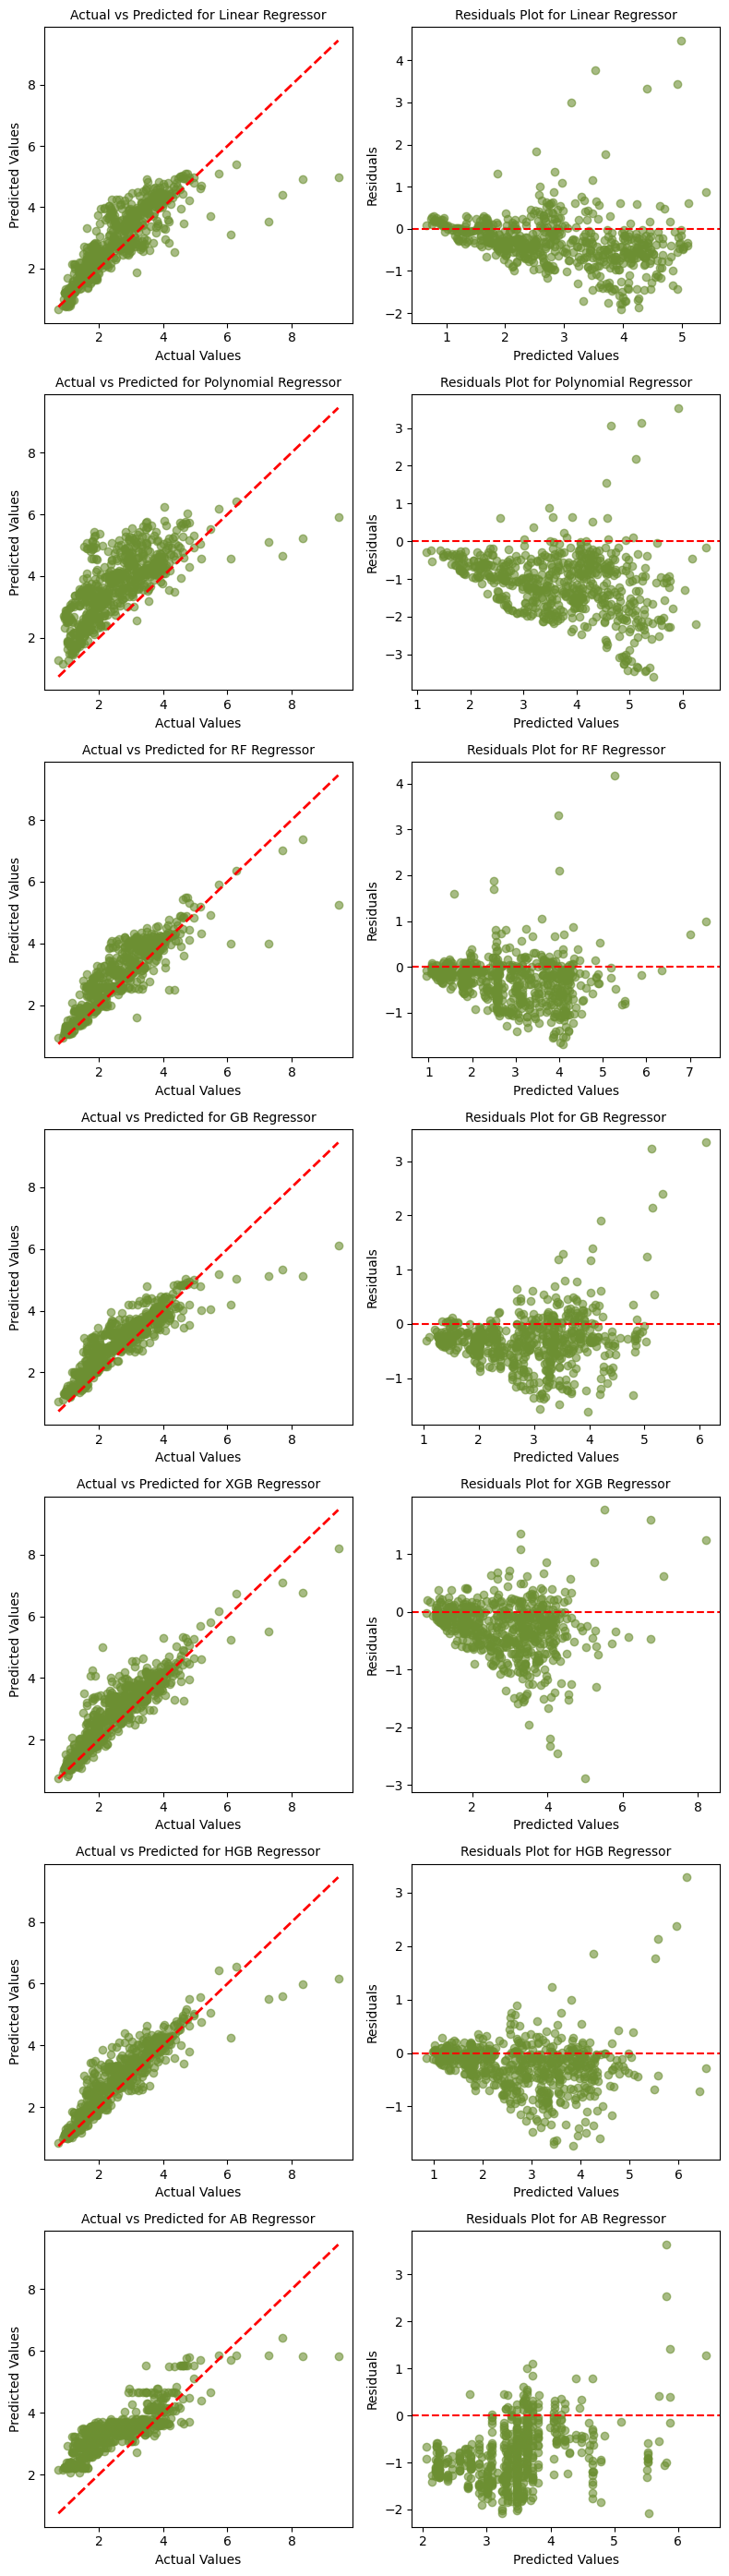

In [634]:
# Define the polynomial regression model (degree 2)
model_types = {
        "Linear Regressor": LinearRegression(),
        "Polynomial Regressor": make_pipeline(PolynomialFeatures(degree=2), Ridge()),
        "RF Regressor": RandomForestRegressor(random_state=0),
        "GB Regressor": GradientBoostingRegressor(random_state=0),
        "XGB Regressor": XGBRegressor(random_state=0),
        "HGB Regressor": HistGradientBoostingRegressor(random_state=0),
        "AB Regressor": AdaBoostRegressor(random_state=0)
    }

results, fig = baseline_model_comparison(model_types, X_train, X_test, y_train, y_test)
results

The Random Forest (RF) regressor achieved the lowest Mean Absolute Percentage Error (MAPE) of 71.43%, indicating that, on average, the model's sales predictions deviated by 71.43% units from the actual values. The HistGradientBoosting (HGB) and XGBoost (XGB) regressors followed, with MAPEs of 99.45% and 122.90%, respectively. Although these three models were the best performing overall, the models' predictions deviated from the actual values significantly. 

The actual vs predicted value plots for these models indicated a moderate fit overall, though some scattered points suggest areas of underperformance, particularly for higher value predictions. The residual plots further highlight a tendency for larger errors when predicting higher sales values.

In terms of computational efficiency, the XGB regressor excelled with a fit times below 0.07 seconds and score times below 0.004 seconds. The HGB and RF regressors were less efficient with fit times of 0.16 and 0.36, and score times of 0.004 and 0.009 seconds, respectively.

Overall, the RF regressor has the best prediction accuracy, although the accuracy needs improvement, while the XGB and HGB regressors offer superior training speed, making them ideal candidates for time-sensitive applications. In the following section, we will focus on fine-tuning the RF, XGB, and HGB models to enhance their performance, ultimately selecting the best model among the three.

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">7.3. Model Fine Tuning</h2>

In the previous section a baseline comparison of various non-linear models was performed to evaluate which models were best at predicting avocado sales. Three of the top performing models, the RF, XGB and HGB regressors, were selected for hyperparameter tuning. Hyperparameter tuning involves experimenting with various combinations of model settings to select an optimal configuration. To test all hyperparameter combinations for each model, a grid search cross-validation method will be used. MLFlow, an experiment tracking tool, will be used to keep track of the models' performance at various setting configurations. 

The hyperparameters to be tuned are:

*RF Regressor:*
* `n_estimators`: The number of decision trees that will be built.
* `max_features`: The size of the random subsets of features to consider when splitting at a decision tree node.

*XGB Regressor:*
* `n_estimators`: The number of decision trees that will be built.
* `learning_rate`: The rate at which the algorithm learns from each iteration.
* `max_depth`: The maximum depth of a decision tree. 
* `scoring`: The metric/s used to assess model performance.

*HGB Regressor:*
* `max_iter`: The number of decision trees that will be built.
* `learning_rate`: The rate at which the algorithm learns from each iteration.
* `max_depth`: The maximum depth of a decision tree.
* `max_leaf_nodes`: The maximum number of leaf nodes in a decision tree.
* `l2_regularization`: The L2 regularisation term used to reduce overfitting.
* `scoring`: The metric/s used to assess model performance.

Start by selecting the models for fine-tuning and hyperparameters to be tuned.

In [635]:
# Select models
model_types = {
        "Polynomial Regressor": make_pipeline(PolynomialFeatures(degree=2), Ridge()),
        "RF Regressor": RandomForestRegressor(random_state=0),
        "XGB Regressor": XGBRegressor(random_state=0),
        "HGB Regressor": HistGradientBoostingRegressor(random_state=0)
    }

# Select hyperparameters
hyperparameters = {
    "Polynomial Regressor": {
    },
    "RF Regressor": {
        "model__n_estimators": [100, 200],
        'model__max_features': [2, 5, 9],
    },
    "XGB Regressor": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.01, 0.05, 0.10],
        "model__max_depth": [5, 7, 9],
        "model__scoring": ['neg_mean_absolute_percentage_error']
    },
    "HGB Regressor": {
        "model__max_iter": [100, 200],
        "model__learning_rate": [0.01, 0.05, 0.10],
        "model__max_depth": [5, 7, 9],
        "model__max_leaf_nodes": [50, 100],
        "model__l2_regularization": [0, 0.1, 0.25, 0.50],
        "model__scoring": ['neg_mean_absolute_percentage_error']
    }
}

Fine-tune the models. Keep track of the models' performance at different hyperparameter configurations.

In [636]:
# Initialise an MLFlow experiment to track model performance

# # Set a tracking uri
# mlflow.set_tracking_uri("http://localhost:5000")

# # Disable autologging
# mlflow.autolog(disable=True)

# # Set parameters
# experiment_name = "Regressor Hyperparameter-tuning"

# # Create an MLFlow experiment
# if not mlflow.get_experiment_by_name(experiment_name):
#     mlflow.create_experiment(name=experiment_name)

# experiment = mlflow.get_experiment_by_name(experiment_name)

grid_models = {}
grid_model_results = {}

for name, model in model_types.items():
    # Test hyperparameter combinations
    cv = KFold(n_splits=5, shuffle=False)

    # Define feature transformations
    feat_transform = make_column_transformer(
        (OneHotEncoder(drop='first'), ['region']),
        (StandardScaler(), ['year', 'average_unit_price', 'month', 'quarter', 'week']),
        ("passthrough", ["peak_season"]),
        verbose_feature_names_out = False,
        remainder="drop"
    )
    # Define pipeline
    pipeline = Pipeline([('transform', feat_transform), ('model', model)])

    grid_model = GridSearchCV(estimator=pipeline,
                              param_grid=hyperparameters[name],
                              n_jobs=-1,
                              cv=cv,
                              scoring='neg_mean_absolute_percentage_error')
    
    grid_model.fit(X_train, y_train)

    # Store the models
    grid_models[name] = grid_model

    # Extract results for all hyperparameter combinations (i.e. each run)
    results = pd.DataFrame(grid_model.cv_results_)[
        ["params", "mean_test_score", "mean_fit_time", "mean_score_time"]
    ]
    results["mean_mape_score"] = -results["mean_test_score"]
    results.drop(columns=["mean_test_score"], inplace=True)

    # Store the drid search results
    grid_model_results[name] = results

    results_arr = results.values

    # # Save the results from each run
    # for i, run in enumerate(results_arr):
    #     with mlflow.start_run(run_name=f"{name}_run_{i}", experiment_id=experiment.experiment_id):
    #         # Log parameters
    #         mlflow.log_params(run[0])
    #         # Log metrics
    #         metrics = {
    #             "Mean MAPE": -run[1],
    #             "Mean Fit Time": run[2],
    #             "Mean Test Time": run[3],
    #         }
    #         mlflow.log_metrics(metrics)

Compare the results of the best performing fine-tuned models.

In [637]:
print('Best performing fine-tuned RF Regressor:')
grid_model_results['RF Regressor'].nsmallest(n=1, columns=['mean_mape_score'])

Best performing fine-tuned RF Regressor:


,params,mean_fit_time,mean_score_time,mean_mape_score
5,"{'model__max_features': 9, 'model__n_estimator...",0.658285,0.015927,0.11918


In [638]:
print('Best performing fine-tuned XGB Regressor:')
grid_model_results['XGB Regressor'].nsmallest(n=1, columns=['mean_mape_score'])

Best performing fine-tuned XGB Regressor:


,params,mean_fit_time,mean_score_time,mean_mape_score
13,"{'model__learning_rate': 0.1, 'model__max_dept...",0.12708,0.009246,0.108447


In [639]:
print('Best performing fine-tuned HGB Regressor:')
grid_model_results['HGB Regressor'].nsmallest(n=1, columns=['mean_mape_score'])

Best performing fine-tuned HGB Regressor:


,params,mean_fit_time,mean_score_time,mean_mape_score
62,"{'model__l2_regularization': 0.1, 'model__lear...",0.300001,0.017986,0.109292


After fine-tuning, all models showed lower MAPE scores, indicating a reduction in the error of sales predictions. However, the models' accuracy was still low with around 70% deviation from the actual values. Among the fine-tuned models, the RF regressor emerged as the best-performing model, achieving the lowest MAPE of 67.86%.

The best parameters for the models after fine-tuning are as follows:

In [640]:
print('Best performing fine-tuned RF Regressor parameters:')
grid_models['RF Regressor'].best_params_

Best performing fine-tuned RF Regressor parameters:


{'model__max_features': 9, 'model__n_estimators': 200}

In [641]:
print('Best performing fine-tuned XGB Regressor parameters:')
grid_models['XGB Regressor'].best_params_

Best performing fine-tuned XGB Regressor parameters:


{'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__n_estimators': 200,
 'model__scoring': 'neg_mean_absolute_percentage_error'}

In [642]:
print('Best performing fine-tuned HGB Regressor parameters:')
grid_models['HGB Regressor'].best_params_

Best performing fine-tuned HGB Regressor parameters:


{'model__l2_regularization': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__max_iter': 200,
 'model__max_leaf_nodes': 50,
 'model__scoring': 'neg_mean_absolute_percentage_error'}

<h2 style="color: white; background-color: #6C8F32; margin: 8px; padding: 15px; padding-left: 15px; border-radius: 4px;">7.4. Final Model</h2>

Based on the results above, the fine-tuned RF Regressor achieved the best performance in predicting avocado sales. In this section, we will train the model using the full set of training data, and evaluate the model's performance on the unseen test data. Additionally, we will visualise the predicted vs actual values, and model residuals for the test data.

Start by training the fine-tuned model on the full training dataset.

In [643]:
best_model = grid_models['RF Regressor'].best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['region']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'average_unit_price',
                                                   'month', 'quarter',
                                                   'week']),
                                                 ('passthrough', 'passthrough',
                                                  ['peak_season'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RandomForestRegressor(max_features=9, n_estimators=200,
                                       random_state=0))])

Evaluate the model's performance on unseen test data.

Model RMSE: 0.5896920813925023
Model MAPE: 0.17748306505437145


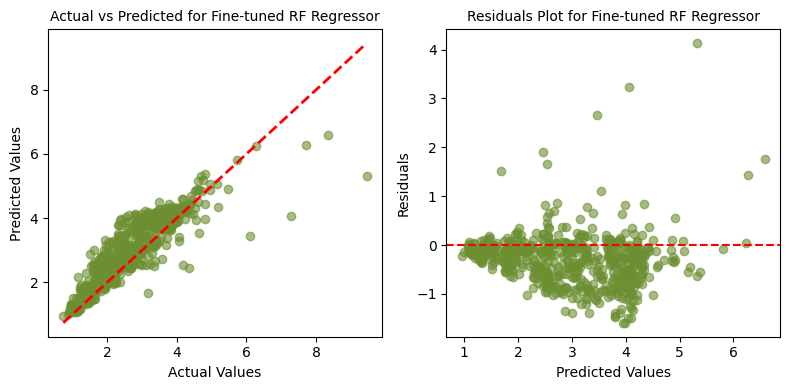

In [644]:
# Generate predictions for test data
y_pred = best_model.predict(X_test)

# Evaluate RMSE and MAPE scores
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Model RMSE: {rmse}")
print(f"Model MAPE: {mape}")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Plot actual vs predicted values
axs[0].scatter(y_test, y_pred, alpha=0.6, color='#6C8F32')
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title(f'Actual vs Predicted for Fine-tuned RF Regressor', fontsize=10)

# Plot residuals
residuals = y_test - y_pred
axs[1].scatter(y_pred, residuals, alpha=0.6, color='#6C8F32')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')
axs[1].set_title(f'Residuals Plot for Fine-tuned RF Regressor', fontsize=10)

plt.tight_layout()
plt.show()

Features with the most impact on sales predictions.

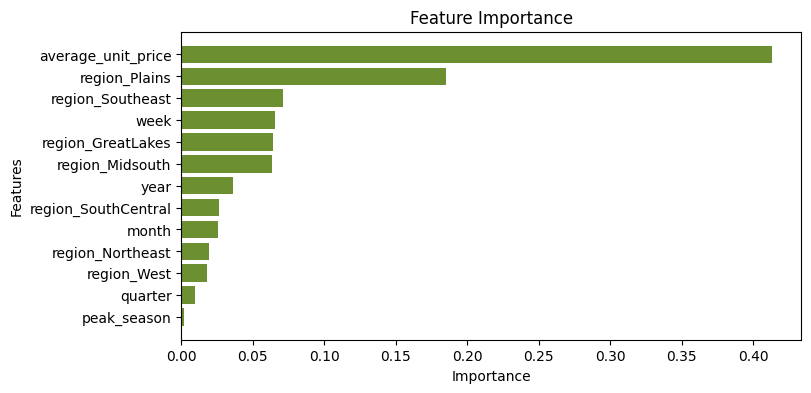

In [645]:
feature_importance = best_model.named_steps['model'].feature_importances_
feature_names = best_model.named_steps['transform'].get_feature_names_out()
feature_importance_df = pd.DataFrame({"Feature":feature_names, "Importance":feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance")

plt.figure(figsize=(8,4))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='#6C8F32')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.grid(False)
plt.show()

Plot the predicted demand vs the actual demand

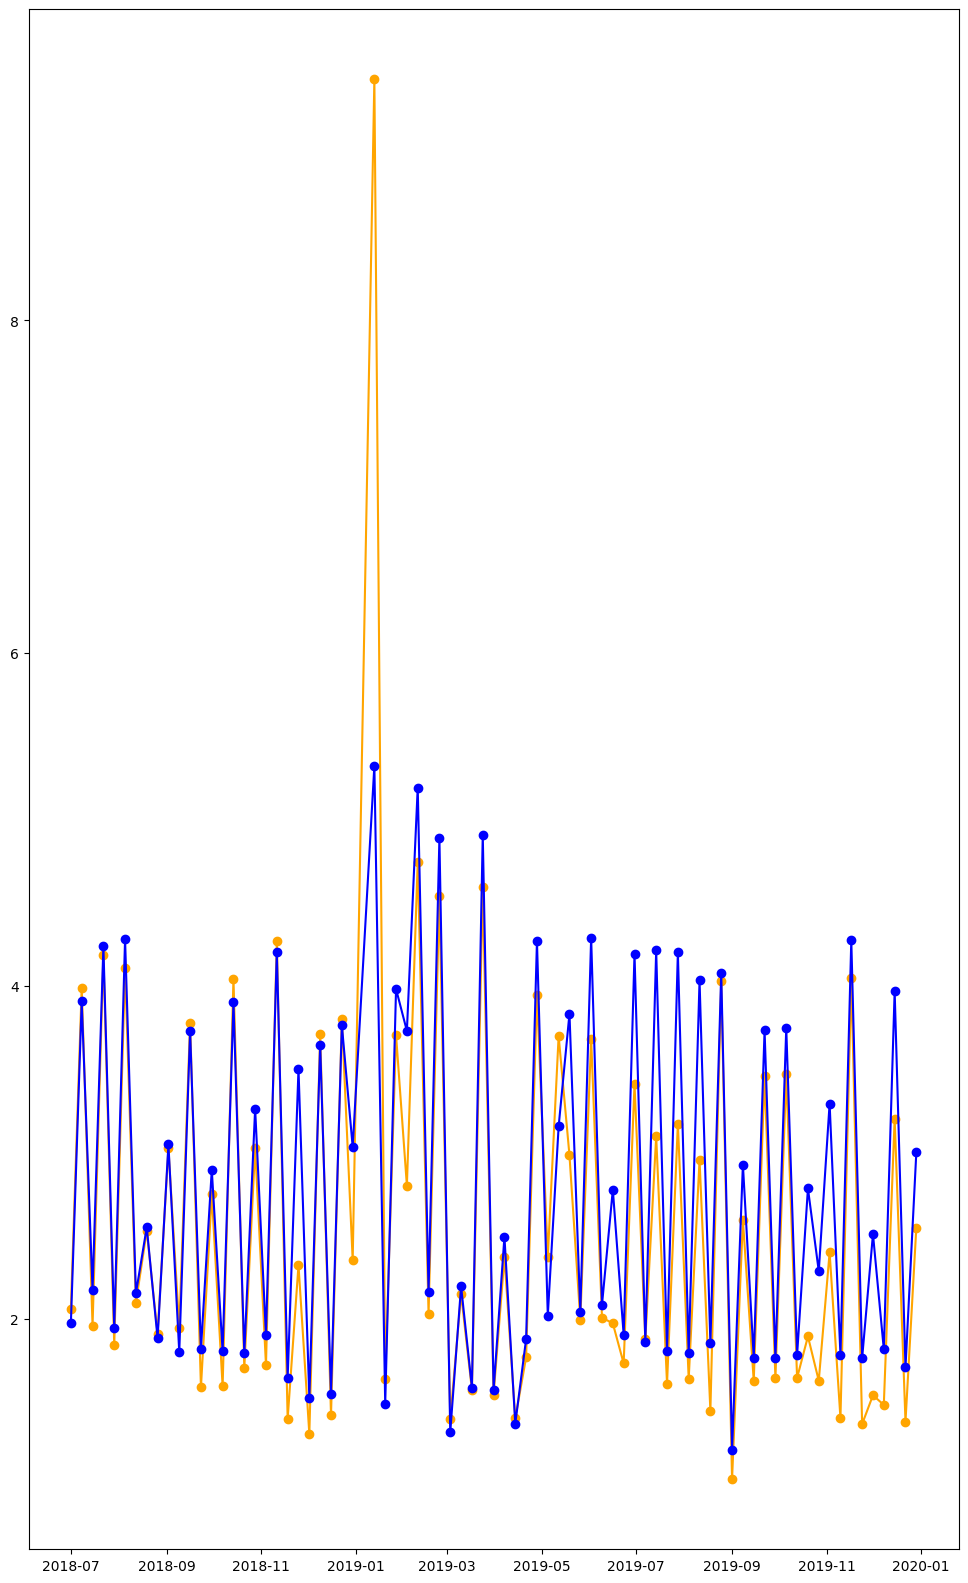

In [646]:
plt.plot(y_test.iloc[::8], color="orange", marker="o", label="Average Unit Price")
plt.plot(pd.DataFrame(data=y_pred, index=y_test.index).iloc[::8], color="blue", marker="o", label="Average Unit Price")

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="conclusion" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">8. Conclusion</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">

<hr style="border: none; border-top: 1px solid black; height: 1px;">
<h2 id="references" style="color: white; background-color: #356211; margin: 10px; padding: 15px; padding-left: 15px; border-radius: 4px;">9. References</h2>
<hr style="border: none; border-top: 1px solid black; height: 1px;">